# Experimentos con el subconjunto de 10 clases

Este notebook replica el pipeline de `dataExperiments.ipynb` pero usando el pickle filtrado con las 10 clases (`Dataset/ucf101_2d_10cls.pkl`).
Ejecuta las celdas en orden: carga → dataset/transforms → dataloaders → entrenamiento mínimo → evaluación.

In [1]:
# Imports y rutas al pickle y mapping
import pickle
from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

ROOT = Path('.')
PICKLE_10CLS = ROOT / 'Dataset' / 'ucf101_2d_10cls.pkl'
MAPPING_FILE = ROOT / 'Dataset' / 'label_mapping_10cls.json'
print('Looking for filtered pickle at:', PICKLE_10CLS)

Looking for filtered pickle at: Dataset\ucf101_2d_10cls.pkl


In [2]:
# Carga del pickle filtrado y creación de df_ann + annotations_summary_10cls.csv
if not PICKLE_10CLS.exists():
    raise FileNotFoundError(f'Filtered pickle not found: {PICKLE_10CLS}. Run scripts/create_10class_subset.py first.')

with open(PICKLE_10CLS, 'rb') as f:
    data = pickle.load(f)

annotations = data.get('annotations') or []
print(f'Loaded {len(annotations)} annotations from filtered pickle')

rows = []
for ann in annotations:
    kp = ann.get('keypoint')
    kp_shape = None
    try:
        if kp is not None:
            kp_shape = np.array(kp).shape
    except Exception:
        kp_shape = None
    rows.append({
        'frame_dir': ann.get('frame_dir'),
        'total_frames': ann.get('total_frames'),
        'img_shape': ann.get('img_shape'),
        'original_shape': ann.get('original_shape'),
        'label': int(ann.get('label')) if ann.get('label') is not None else None,
        'keypoint_shape': kp_shape,
        'has_keypoint_score': ('keypoint_score' in ann) and (ann.get('keypoint_score') is not None)
    })

df_ann = pd.DataFrame(rows)
csv_path = 'annotations_summary_10cls.csv'
df_ann.to_csv(csv_path, index=False)
print(f'Saved annotations summary to {csv_path}')

if MAPPING_FILE.exists():
    with open(MAPPING_FILE, 'r', encoding='utf-8') as f:
        mapping = json.load(f)
    print('Loaded label mapping (old->new):', mapping)
else:
    mapping = None

df_ann.head()

# --- Performance optimization: pre-convert keypoints and scores to numpy arrays once ---
# This avoids repeated `np.array(...)` conversions inside Dataset.__getitem__ which are expensive.
print('Pre-converting keypoint lists to numpy arrays in memory (this may use RAM but speeds up __getitem__)')
for i, ann in enumerate(annotations):
    kp = ann.get('keypoint')
    if kp is not None and not hasattr(kp, 'shape'):
        try:
            ann['keypoint'] = np.asarray(kp, dtype=np.float32)
        except Exception:
            # leave as is if conversion fails
            ann['keypoint'] = kp
    # convert scores if present
    if 'keypoint_score' in ann and ann['keypoint_score'] is not None and not hasattr(ann['keypoint_score'], 'shape'):
        try:
            ann['keypoint_score'] = np.asarray(ann['keypoint_score'], dtype=np.float32)
        except Exception:
            pass

print('Done pre-conversion of keypoints.')

Loaded 1413 annotations from filtered pickle
Saved annotations summary to annotations_summary_10cls.csv
Loaded label mapping (old->new): {'10': 0, '16': 1, '25': 2, '59': 3, '89': 4, '88': 5, '7': 6, '55': 7, '38': 8, '12': 9}
Pre-converting keypoint lists to numpy arrays in memory (this may use RAM but speeds up __getitem__)
Done pre-conversion of keypoints.


In [3]:
# NormalizeKeypoints y UCFSkeletonDataset (igual al notebook original)
class NormalizeKeypoints:
    """Normalize keypoints to unit coordinates using image shape.
    Expects sample to contain 'keypoint' (torch.Tensor (T,V,C)) and either
    'img_shape' or 'original_shape' (height, width).
    """
    def __init__(self, shape_key='img_shape'):
        self.shape_key = shape_key
    def __call__(self, sample):
        kp = sample['keypoint']
        shape = sample.get(self.shape_key) or sample.get('original_shape')
        if shape is None:
            return sample
        try:
            h, w = float(shape[0]), float(shape[1])
            if w > 0 and h > 0:
                kp = kp.clone()
                kp[..., 0] = kp[..., 0] / w
                kp[..., 1] = kp[..., 1] / h
                sample['keypoint'] = kp
        except Exception:
            pass
        return sample

class UCFSkeletonDataset(Dataset):
    def __init__(self, annotations_list, transform=None, select_best_by_score=True, dtype=torch.float32):
        self.annotations = annotations_list
        self.transform = transform
        self.select_best_by_score = select_best_by_score
        self.dtype = dtype
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, idx):
        ann = self.annotations[idx]
        kp = ann.get('keypoint')
        kp_score = ann.get('keypoint_score', None)
        kp = np.array(kp)  # M x T x V x C
        if kp.ndim != 4:
            raise ValueError(f'Unexpected keypoint shape for idx={idx}: {kp.shape}')
        M = kp.shape[0]
        person_idx = 0
        if M > 1 and kp_score is not None and self.select_best_by_score:
            scores = np.array(kp_score)
            mean_scores = scores.mean(axis=(1,2))
            person_idx = int(mean_scores.argmax())
        person_kp = kp[person_idx]  # T x V x C
        tensor_kp = torch.from_numpy(person_kp.astype(np.float32))
        sample = {
            'keypoint': tensor_kp,
            'label': int(ann.get('label')) if ann.get('label') is not None else None,
            'frame_dir': ann.get('frame_dir'),
            'total_frames': ann.get('total_frames'),
            'img_shape': ann.get('img_shape'),
            'original_shape': ann.get('original_shape')
        }
        if kp_score is not None:
            score_np = np.array(kp_score)[person_idx]
            sample['score'] = torch.from_numpy(score_np.astype(np.float32))
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

# instantiate normalize and test dataset
normalize = NormalizeKeypoints(shape_key='img_shape')
ds_full = UCFSkeletonDataset(annotations, transform=normalize)
print('Dataset length (10cls):', len(ds_full))
print('Example sample keys:', list(ds_full[0].keys()))

Dataset length (10cls): 1413
Example sample keys: ['keypoint', 'label', 'frame_dir', 'total_frames', 'img_shape', 'original_shape', 'score']


In [4]:
# Collate function (right-pad) y DataLoaders (small batch sizes recomendados)
def pad_sequence_kp_right(kps):
    T_max = max(t.shape[0] for t in kps)
    V = kps[0].shape[1]
    C = kps[0].shape[2]
    padded, masks = [], []
    for t in kps:
        T = t.shape[0]
        pad_len = T_max - T
        if pad_len > 0:
            pad_tensor = torch.zeros((pad_len, V, C), dtype=t.dtype)
            p = torch.cat([pad_tensor, t], dim=0)
            mask = torch.cat([torch.zeros((pad_len, V)), torch.ones((T, V))], dim=0)
        else:
            p = t
            mask = torch.ones((T, V))
        padded.append(p)
        masks.append(mask)
    batch_kp = torch.stack(padded, dim=0)
    batch_mask = torch.stack(masks, dim=0)
    return batch_kp, batch_mask

def ucf_collate_fn_right(batch):
    kps = [item['keypoint'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    frame_dirs = [item['frame_dir'] for item in batch]
    total_frames = [item['total_frames'] for item in batch]
    scores = [item.get('score') for item in batch]
    batch_kp, batch_mask = pad_sequence_kp_right(kps)
    batch_scores = None
    if any(s is not None for s in scores):
        scores_repl = []
        for i, s in enumerate(scores):
            if s is None:
                T = kps[i].shape[0]
                V = kps[i].shape[1]
                scores_repl.append(torch.zeros((T, V), dtype=torch.float32))
            else:
                scores_repl.append(s)
        T_max = batch_kp.shape[1]
        padded_scores = []
        for s in scores_repl:
            pad_len = T_max - s.shape[0]
            if pad_len > 0:
                pad = torch.zeros((pad_len, s.shape[1]), dtype=s.dtype)
                padded_scores.append(torch.cat([pad, s], dim=0))
            else:
                padded_scores.append(s)
        batch_scores = torch.stack(padded_scores, dim=0)
    return {'keypoint': batch_kp, 'mask': batch_mask, 'label': labels, 'frame_dir': frame_dirs, 'total_frames': total_frames, 'score': batch_scores}

# Create a simple train/val split and DataLoaders (small batches for GTX 1650)
indices = np.arange(len(annotations))
try:
    from sklearn.model_selection import train_test_split
    train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=df_ann['label'].values, random_state=42)
except Exception:
    rng = np.random.RandomState(42)
    perm = rng.permutation(len(indices))
    split = int(0.8 * len(indices))
    train_idx = perm[:split]
    val_idx = perm[split:]

train_anns = [annotations[i] for i in train_idx]
val_anns = [annotations[i] for i in val_idx]

train_ds = UCFSkeletonDataset(train_anns, transform=normalize)
val_ds = UCFSkeletonDataset(val_anns, transform=normalize)

# Performance: try pin_memory=True and experiment with num_workers (0..4). On Windows, spawn overhead can make small num_workers faster.
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=ucf_collate_fn_right, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=ucf_collate_fn_right, num_workers=0, pin_memory=True)
print('Created train/val DataLoaders — train size:', len(train_ds), 'val size:', len(val_ds))

Created train/val DataLoaders — train size: 1130 val size: 283


In [7]:
# Entrenamiento mínimo (1 época) que guarda lstm_10cls_minimal.pt (con weight decay básico)
import torch.nn as nn
from Models.lstm_model import SkeletonLSTM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = int(df_ann['label'].nunique())
model = SkeletonLSTM(num_joints=17, in_channels=2, num_classes=num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
n_epochs = 30
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    for batch in train_loader:
        kp = batch['keypoint'].to(device)
        labels_b = batch['label'].to(device)
        optimizer.zero_grad()
        logits = model(kp)
        loss = criterion(logits, labels_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels_b.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labels_b).sum().item()
        running_total += labels_b.size(0)
    train_loss = running_loss / running_total
    train_acc = running_correct / running_total
    print(f'Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}')
ckpt_path = 'lstm_10cls_minimal.pt'
torch.save({'model_state': model.state_dict(), 'num_classes': num_classes}, ckpt_path)
print('Saved checkpoint to', ckpt_path)

Epoch 1: train_loss=2.2345, train_acc=0.1655
Epoch 2: train_loss=1.9369, train_acc=0.2717
Epoch 2: train_loss=1.9369, train_acc=0.2717
Epoch 3: train_loss=1.8227, train_acc=0.3009
Epoch 3: train_loss=1.8227, train_acc=0.3009
Epoch 4: train_loss=1.6339, train_acc=0.3735
Epoch 4: train_loss=1.6339, train_acc=0.3735
Epoch 5: train_loss=1.5840, train_acc=0.3717
Epoch 5: train_loss=1.5840, train_acc=0.3717
Epoch 6: train_loss=1.9856, train_acc=0.2558
Epoch 6: train_loss=1.9856, train_acc=0.2558
Epoch 7: train_loss=1.7837, train_acc=0.3301
Epoch 7: train_loss=1.7837, train_acc=0.3301
Epoch 8: train_loss=1.7424, train_acc=0.3513
Epoch 8: train_loss=1.7424, train_acc=0.3513
Epoch 9: train_loss=1.5987, train_acc=0.3965
Epoch 9: train_loss=1.5987, train_acc=0.3965
Epoch 10: train_loss=1.5740, train_acc=0.3965
Epoch 10: train_loss=1.5740, train_acc=0.3965
Epoch 11: train_loss=1.4467, train_acc=0.4292
Epoch 11: train_loss=1.4467, train_acc=0.4292
Epoch 12: train_loss=1.4751, train_acc=0.4177
Epoch

Saved per-class metrics to per_class_metrics_10cls.csv


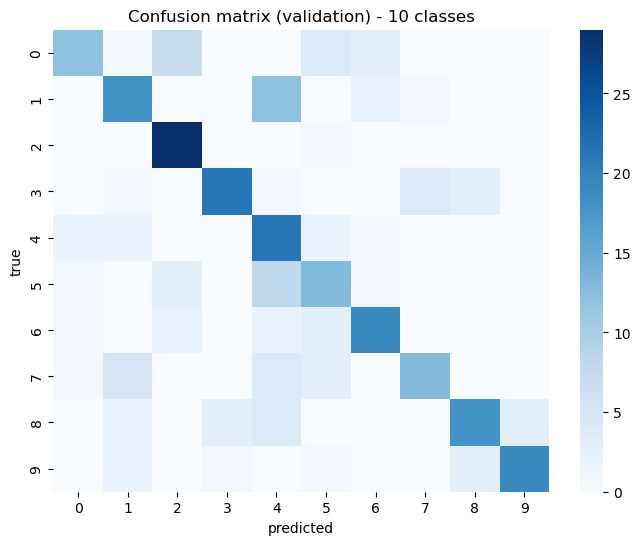

In [8]:
# Evaluación que guarda per_class_metrics_10cls.csv y muestra la matriz de confusión
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar checkpoint (si no está cargado ya)
ckpt = 'lstm_10cls_minimal.pt'
if not Path(ckpt).exists():
    raise FileNotFoundError(f'Checkpoint not found: {ckpt}. Run the training cell first.')
model.load_state_dict(torch.load(ckpt, map_location=device)['model_state'])
model.to(device)
model.eval()
all_y, all_pred = [], []
with torch.no_grad():
    for batch in val_loader:
        kp = batch['keypoint'].to(device)
        labels_b = batch['label'].to(device)
        logits = model(kp)
        preds = logits.argmax(dim=1)
        all_y.append(labels_b.cpu().numpy())
        all_pred.append(preds.cpu().numpy())
all_y = np.concatenate(all_y)
all_pred = np.concatenate(all_pred)
labels_unique = np.unique(all_y)
precision, recall, f1, support = precision_recall_fscore_support(all_y, all_pred, labels=labels_unique, zero_division=0)
per_class = pd.DataFrame({'label': labels_unique, 'precision': precision, 'recall': recall, 'f1': f1, 'support': support})
per_class.to_csv('per_class_metrics_10cls.csv', index=False)
print('Saved per-class metrics to per_class_metrics_10cls.csv')
cm = confusion_matrix(all_y, all_pred, labels=labels_unique)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')
plt.title('Confusion matrix (validation) - 10 classes')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

In [9]:
# Analizar confusiones por pares (true -> pred) y guardar resultados
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix

# Recompute predictions if needed
if 'all_y' not in globals() or 'all_pred' not in globals():
    print('Variables all_y/all_pred no estaban en memoria — recalculando sobre val_loader')
    all_y, all_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            kp = batch['keypoint'].to(device)
            labels_b = batch['label'].to(device)
            logits = model(kp)
            preds = logits.argmax(dim=1)
            all_y.append(labels_b.cpu().numpy())
            all_pred.append(preds.cpu().numpy())
    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)

labels_unique = np.unique(all_y)
cm = confusion_matrix(all_y, all_pred, labels=labels_unique)

pairs = []
for i, t in enumerate(labels_unique):
    for j, p in enumerate(labels_unique):
        if i == j:
            continue
        cnt = int(cm[i, j])
        if cnt > 0:
            pairs.append({'true': int(t), 'pred': int(p), 'count': cnt})

df_pairs = pd.DataFrame(pairs)
if df_pairs.empty:
    print('No hay confusiones (off-diagonal) en la validación.')
else:
    df_pairs = df_pairs.sort_values('count', ascending=False).reset_index(drop=True)
    out_csv = 'confusion_pairs_10cls.csv'
    df_pairs.to_csv(out_csv, index=False)
    print(f'Saved confusion pairs to {out_csv}')
    display(df_pairs.head(20))

    # Top confusion por cada clase verdadera
    top_per_true = df_pairs.sort_values(['true','count'], ascending=[True,False]).groupby('true').first().reset_index()
    print('\nTop predicted class for each true class (most frequent confusion):')
    display(top_per_true)

# Mostrar métricas por clase si existen
if Path('per_class_metrics_10cls.csv').exists():
    print('\nPer-class metrics (loaded from per_class_metrics_10cls.csv):')
    display(pd.read_csv('per_class_metrics_10cls.csv'))
else:
    print('\nper_class_metrics_10cls.csv no encontrado en el directorio.')


Saved confusion pairs to confusion_pairs_10cls.csv


,true,pred,count
0,1,4,12
1,5,4,8
2,0,2,7
3,7,1,5
4,7,4,4
5,8,4,4
6,0,5,4
7,3,7,4
8,7,5,3
9,0,6,3



Top predicted class for each true class (most frequent confusion):


,true,pred,count
0,0,2,7
1,1,4,12
2,2,5,1
3,3,7,4
4,4,0,2
5,5,4,8
6,6,5,3
7,7,1,5
8,8,4,4
9,9,8,3



Per-class metrics (loaded from per_class_metrics_10cls.csv):


,label,precision,recall,f1,support
0,0,0.705882,0.444444,0.545455,27
1,1,0.580645,0.545455,0.562500,33
2,2,0.707317,0.966667,0.816901,30
3,3,0.840000,0.700000,0.763636,30
4,4,0.403846,0.750000,0.525000,28
5,5,0.481481,0.500000,0.490566,26
6,6,0.730769,0.703704,0.716981,27
7,7,0.722222,0.500000,0.590909,26
8,8,0.750000,0.600000,0.666667,30
9,9,0.863636,0.730769,0.791667,26


In [10]:
# Nuevo entrenamiento (celda nueva): AMP + weighted CrossEntropy + validación y guardado del mejor checkpoint
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from Models.lstm_model import SkeletonLSTM

# Config dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Using CUDA device:', torch.cuda.get_device_name(0))
print('Device:', device)

# Compute class weights from df_ann
labels_arr = df_ann['label'].values
classes, counts = np.unique(labels_arr, return_counts=True)
weights = counts.sum() / (len(classes) * counts)
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
print('Class weights per label:', dict(zip(classes.tolist(), weights.tolist())))

# Model, loss, optimizer
num_classes = int(df_ann['label'].nunique())
model = SkeletonLSTM(num_joints=17, in_channels=2, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# AMP
use_amp = (device.type == 'cuda')
scaler = torch.cuda.amp.GradScaler(enabled=use_amp) if use_amp else None
print('Using AMP:', use_amp)

# Training loop with validation each epoch
n_epochs = 20
best_val_acc = 0.0
history = []
for epoch in range(1, n_epochs + 1):
    t0 = time.time()
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for batch in train_loader:
        kp = batch['keypoint'].to(device)
        labels_b = batch['label'].to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(kp)
            loss = criterion(logits, labels_b)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * labels_b.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labels_b).sum().item()
        running_total += labels_b.size(0)

    train_loss = running_loss / running_total if running_total > 0 else 0.0
    train_acc = running_correct / running_total if running_total > 0 else 0.0

    # Validation
    model.eval()
    v_loss = 0.0
    v_correct = 0
    v_total = 0
    with torch.no_grad():
        for batch in val_loader:
            kp = batch['keypoint'].to(device)
            labels_b = batch['label'].to(device)
            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(kp)
                loss = criterion(logits, labels_b)
            v_loss += loss.item() * labels_b.size(0)
            preds = logits.argmax(dim=1)
            v_correct += (preds == labels_b).sum().item()
            v_total += labels_b.size(0)

    val_loss = v_loss / v_total if v_total > 0 else 0.0
    val_acc = v_correct / v_total if v_total > 0 else 0.0
    epoch_time = time.time() - t0

    history.append({'epoch': epoch, 'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc, 'epoch_time': epoch_time})
    print(f'Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, time={epoch_time:.1f}s')

    # Guardar mejor checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict(), 'num_classes': num_classes, 'epoch': epoch, 'val_acc': val_acc}, 'best_10cls.pt')
        print(f'New best model saved (val_acc={val_acc:.4f})')

# Al final, guardar checkpoint final y el historial
torch.save({'model_state': model.state_dict(), 'num_classes': num_classes}, 'lstm_10cls_amp_weighted.pt')
try:
    pd.DataFrame(history).to_csv('training_history_10cls.csv', index=False)
    print('Saved training history to training_history_10cls.csv')
except Exception as e:
    print('Warning: could not save history:', e)
print('Training cell finished.')


Device: cpu
Class weights per label: {0: 1.0544776119402985, 1: 0.8668711656441718, 2: 0.942, 3: 0.9357615894039735, 4: 1.0092857142857143, 5: 1.0786259541984733, 6: 1.0544776119402985, 7: 1.0704545454545455, 8: 0.9612244897959183, 9: 1.0786259541984733}
Using AMP: False


C:\Users\edosa\AppData\Local\Temp\ipykernel_27892\1259358662.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
C:\Users\edosa\AppData\Local\Temp\ipykernel_27892\1259358662.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
C:\Users\edosa\AppData\Local\Temp\ipykernel_27892\1259358662.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 1: train_loss=2.1567, train_acc=0.1619, val_loss=1.8708, val_acc=0.2650, time=181.7s
New best model saved (val_acc=0.2650)
Epoch 2: train_loss=1.8407, train_acc=0.2708, val_loss=1.6151, val_acc=0.3286, time=165.1s
New best model saved (val_acc=0.3286)
Epoch 2: train_loss=1.8407, train_acc=0.2708, val_loss=1.6151, val_acc=0.3286, time=165.1s
New best model saved (val_acc=0.3286)
Epoch 3: train_loss=1.6595, train_acc=0.3522, val_loss=1.5705, val_acc=0.3710, time=154.5s
New best model saved (val_acc=0.3710)
Epoch 3: train_loss=1.6595, train_acc=0.3522, val_loss=1.5705, val_acc=0.3710, time=154.5s
New best model saved (val_acc=0.3710)
Epoch 4: train_loss=1.5850, train_acc=0.3779, val_loss=1.4885, val_acc=0.4099, time=136.0s
New best model saved (val_acc=0.4099)
Epoch 4: train_loss=1.5850, train_acc=0.3779, val_loss=1.4885, val_acc=0.4099, time=136.0s
New best model saved (val_acc=0.4099)
Epoch 5: train_loss=1.5882, train_acc=0.3743, val_loss=1.5087, val_acc=0.3887, time=95.8s
Epoch 5

Saved per-class metrics to per_class_metrics_CE_10cls.csv


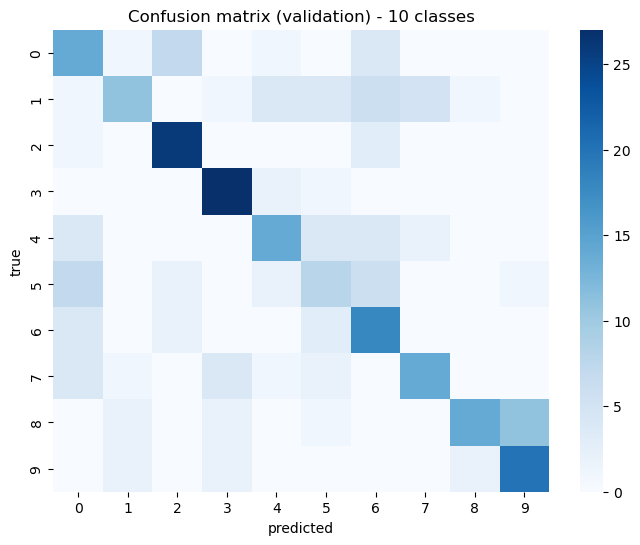

In [11]:
# Evaluación que guarda per_class_metrics_10cls.csv y muestra la matriz de confusión
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar checkpoint (si no está cargado ya)
ckpt = 'best_10cls.pt'
if not Path(ckpt).exists():
    raise FileNotFoundError(f'Checkpoint not found: {ckpt}. Run the training cell first.')
model.load_state_dict(torch.load(ckpt, map_location=device)['model_state'])
model.to(device)
model.eval()
all_y, all_pred = [], []
with torch.no_grad():
    for batch in val_loader:
        kp = batch['keypoint'].to(device)
        labels_b = batch['label'].to(device)
        logits = model(kp)
        preds = logits.argmax(dim=1)
        all_y.append(labels_b.cpu().numpy())
        all_pred.append(preds.cpu().numpy())
all_y = np.concatenate(all_y)
all_pred = np.concatenate(all_pred)
labels_unique = np.unique(all_y)
precision, recall, f1, support = precision_recall_fscore_support(all_y, all_pred, labels=labels_unique, zero_division=0)
per_class = pd.DataFrame({'label': labels_unique, 'precision': precision, 'recall': recall, 'f1': f1, 'support': support})
per_class.to_csv('per_class_metrics_CE_10cls.csv', index=False)
print('Saved per-class metrics to per_class_metrics_CE_10cls.csv')
cm = confusion_matrix(all_y, all_pred, labels=labels_unique)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')
plt.title('Confusion matrix (validation) - 10 classes')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()